# DATA 620 Project One
## Airline Network Analysis

Author: Kevin Kirby

##  Library and Data Imports

The dataset I chose is the [EU Air Transportation Multiplex Network](https://manliodedomenico.com/data.php), which represents airlines operating at airports as a series of networks:

* Nodes equal airports
* Edges equal flights between airports
* Layers equal different airlines, with each layer representing separate networks
* Categorical variable is the layer ID, representing the airline

These next few cells:
* Import required libraries
* Turn graph files into pandas dataframes
* Show small sample of each dataframe


In [17]:
import pandas as tian
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network
from scipy.stats import f_oneway, kruskal, ttest_ind

In [2]:
airline_edges = tian.read_csv("/Users/uwsthoughts/Desktop/masters_local/EUAir_Multiplex_Transport/Dataset/EUAirTransportation_multiplex.edges", sep=" ", header=None, names=["layer", "source", "target", "weight"])
airline_layers = tian.read_csv("/Users/uwsthoughts/Desktop/masters_local/EUAir_Multiplex_Transport/Dataset/EUAirTransportation_layers.txt", sep=" ", header=1, names=["node_id", "node_label"])
airline_nodes = tian.read_csv("/Users/uwsthoughts/Desktop/masters_local/EUAir_Multiplex_Transport/Dataset/EUAirTransportation_nodes.txt", sep=" ", header=1,  names=["node_id", "node_label", "longitude", "latitude"])

In [3]:
airline_nodes.head(5)

,node_id,node_label,longitude,latitude
0,2,EDDF,8.570555,50.033333
1,3,EDDK,7.142779,50.865833
2,4,EGNX,-1.328055,52.831112
3,5,EGTE,-3.413888,50.734444
4,6,LTBJ,27.155001,38.289168


In [4]:
airline_layers.head(5)

,node_id,node_label
0,2,Ryanair
1,3,Easyjet
2,4,British_Airways
3,5,Turkish_Airlines
4,6,Air_Berlin


In [5]:
airline_edges.head(5)

,layer,source,target,weight
0,1,1,2,1.0
1,1,1,38,1.0
2,1,2,7,1.0
3,1,2,8,1.0
4,1,2,10,1.0


## Data cleanup

These ensure the latitude and longtitude values floats and the sources and targets of the edges are integers. I was running into issues with the initial data containing a mix of types and they all needed to be normalized as numbers for this to work.

The geographic locations are mapped to western, central, and eastern Europe according to their longitudes. If I wanted to break them down by northern, central, and southern I would use latitude instead.

In [15]:
airline_nodes["latitude"] = airline_nodes["latitude"].astype(float)
airline_nodes["longitude"] = airline_nodes["longitude"].astype(float)

airline_edges["source"] = airline_edges["source"].astype(int)
airline_edges["target"] = airline_edges["target"].astype(int)

In [7]:
def long_regions(lon):
    if lon < 10:
        return "Western"
    elif lon < 20:
        return "Central"
    else:
        return "Eastern"


airline_nodes["region"] = airline_nodes["longitude"].apply(long_regions)

vns = set(airline_nodes["node_id"])
filtered_eds = airline_edges[airline_edges["source"].isin(vns) & airline_edges["target"].isin(vns)]

print(airline_nodes["region"].value_counts())

region
Western    199
Eastern    133
Central    117
Name: count, dtype: int64


## Mapping the graph

This turns the edges and nodes into a map and visualizes them with Pyvis Network. It takes a hot second to render in Chrome but it is pretty neat. 

In [8]:
airline_graph = nx.Graph()
airline_graph.add_nodes_from(vns)
airline_graph.add_weighted_edges_from(filtered_eds[["source", "target", "weight"]].values)
airline_graph = nx.relabel_nodes(airline_graph, lambda x: int(x))

nt = Network(height='750px', width='100%', notebook=True, cdn_resources='in_line')
nt.from_nx(airline_graph)

In [ ]:
nt.show("/Users/uwsthoughts/Desktop/masters_local/eu_air_network.html")

## Measuring Centrality

Some notable takeaways from the centrality measures:

**Degree:**

* Western airports have the highest average connectivity
    * Standard deviation is also the highest here, probably due a mix of hubs and smaller airports
* Eastern airports have the lowest, most likely due to more rural areas or less direct connections

**Eigenvector**
* Western airports are wel connected to other important airports
    * This makes their place in the overall network very important 
* Eastern airport scored the lowest
    *  More evidence that, based purely on this dataset, these airports play a less important role

In [9]:
centrality_d = nx.degree_centrality(airline_graph)
centrality_eig = nx.eigenvector_centrality(airline_graph, max_iter=1000)

airline_nodes["centrality_degree"] = airline_nodes["node_id"].map(centrality_d)
airline_nodes["centrality_eigenvector"] = airline_nodes["node_id"].map(centrality_eig)

In [10]:
nodes_summary = airline_nodes.groupby("region")[["centrality_degree", "centrality_eigenvector"]].describe()
print(f"nodes summary:\n {nodes_summary}")

nodes summary:
         centrality_degree                                               \
                    count      mean       std  min       25%       50%   
region                                                                   
Central             117.0  0.029724  0.042342  0.0  0.004464  0.011161   
Eastern             133.0  0.015910  0.029315  0.0  0.002232  0.004464   
Western             199.0  0.037845  0.052281  0.0  0.004464  0.013393   

                            centrality_eigenvector                      \
              75%       max                  count      mean       std   
region                                                                   
Central  0.035714  0.220982                  117.0  0.027465  0.039651   
Eastern  0.013393  0.183036                  133.0  0.013884  0.025166   
Western  0.049107  0.250000                  199.0  0.033987  0.044396   

                                                               
                  min       25

## ANOVA and Kruskal-Wallis P-Values

Both of these values rejecrt the null hypothesis that all regions have the same centrality distribution. This confirms what the data above pointed to: airport centrality can and does vary in meaningful ways by geographic region. Western Europe tends to have more centrally connected airports while those in Eastern Europe and much less directly or indirectly connected.

Both the ANOVA and Kruskal-Wallis tests show that degree centrality can vary significantly by region. Head-to-head comparisons show that Eastern European airports have lower centrality than both Western and Central Europe. There was no significant difference between Western and Central Europe.

In [20]:
west = airline_nodes[airline_nodes["region"] == "Western"]["centrality_degree"]
central = airline_nodes[airline_nodes["region"] == "Central"]["centrality_degree"]
east = airline_nodes[airline_nodes["region"] == "Eastern"]["centrality_degree"]

anova_result = f_oneway(west, central, east)
print("ANOVA p-value for centrality degree:\n", anova_result.pvalue, "\n")

kw_result = kruskal(west, central, east)
print("Kruskal-Wallis p-value for centrality degree:\n", kw_result.pvalue, "\n")


print("T-test p-values for centrality degree:")
print("Western vs Central:", ttest_ind(west, central, equal_var=False).pvalue)
print("Western vs Eastern:", ttest_ind(west, east, equal_var=False).pvalue)
print("Central vs Eastern:", ttest_ind(central, east, equal_var=False).pvalue)


ANOVA p-value for centrality degree:
 6.058717800017036e-05 

Kruskal-Wallis p-value for centrality degree:
 1.0043285630305525e-06 

T-test p-values for centrality degree:
Western vs Central: 0.1330175412396053
Western vs Eastern: 1.66590122871149e-06
Central vs Eastern: 0.00344793119355494


## Plotting Centrality

The Degree Centrality by European Region boxplot shows how degree centrality can vary across the European air transportation network. Airports in Western and Central Europe have higher average connectivity than those in Eastern Europe, with Western airports showing the most extreme outliers. What really stands out is just how much Eastern Europe airports are structurally less central than Central or Western Europe airports. It's not a great look that the West dominates in this kind of data and speaks to disparities within Europe.

The Eigenvector Centrality by European Region boxplot shows that Western and Central Europe have stronger connections to nodes that also have strong connections. This reinforces the structural roles these airports play in the network hubs. 

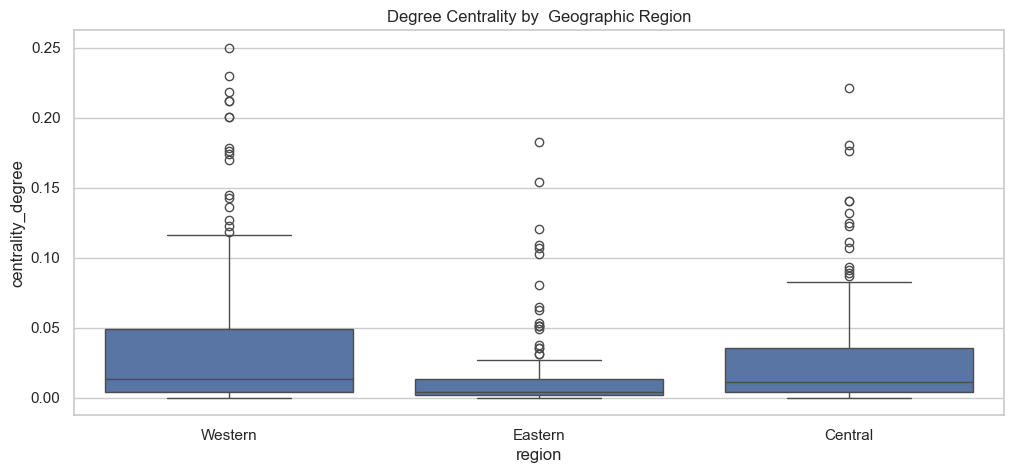

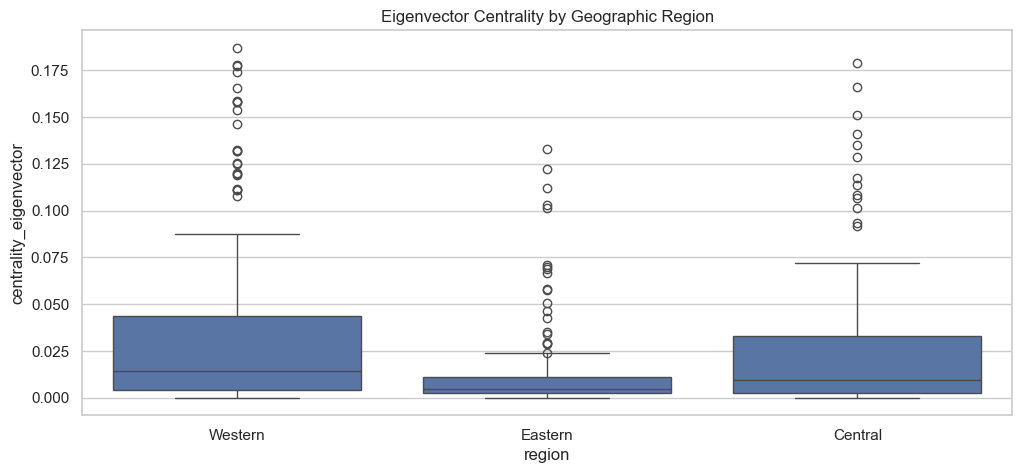

In [14]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))
sns.boxplot(data=airline_nodes, x="region", y="centrality_degree")
plt.title("Degree Centrality by European Region")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=airline_nodes, x="region", y="centrality_eigenvector")
plt.title("Eigenvector Centrality by European Region")
plt.show()